# Part II: Optimizing Neural Network - By minazmeh and aramired

---

In [1]:
import pandas as pd
import numpy as np

# below are used for plotting visuals
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore")

### libraries used for designing neural network and its optimizations

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import time 


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### read the previously cleaned dataset from part1

In [5]:
df = pd.read_csv('dataset_preprocessed.csv')

In [6]:
df

,f1,f2,f3,f4,f5,f6,f7,target
0,6.0,148.0,72.0,35.0,0.0,33.6,0.62700,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.35100,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.67200,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.16700,0
4,0.0,137.0,40.0,35.0,168.0,43.1,1.20025,1
...,...,...,...,...,...,...,...,...
751,9.0,89.0,62.0,0.0,0.0,22.5,NaN,0
752,10.0,101.0,76.0,48.0,180.0,NaN,0.17100,0
753,2.0,122.0,70.0,27.0,NaN,36.8,0.34000,0
754,NaN,121.0,72.0,23.0,112.0,26.2,0.24500,0


In [7]:
X = df.drop('target', axis=1)
y = df['target']


## Reusing code from part1 to scale and split the dataset

In [8]:
numcols = X.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X[numcols] = scaler.fit_transform(X[numcols])
imputer = SimpleImputer(strategy='mean')
X[numcols] = imputer.fit_transform(X[numcols])

# split the dataframe, Train 85% Test 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

#splitting training set into (82.35%) and validation (17.65%),, this makes 70-15-15 ratio of original set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42, stratify=y_train)


# conversion to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [9]:
X

,f1,f2,f3,f4,f5,f6,f7
0,6.693238e-01,0.873572,0.089436,9.328944e-01,-7.890712e-01,2.129253e-01,5.841660e-01
1,-8.518666e-01,-1.202444,-0.331395,5.516574e-01,-7.890712e-01,-7.775992e-01,-3.802131e-01
2,1.277800e+00,2.026915,-0.471672,-1.290988e+00,-7.890712e-01,-1.244561e+00,7.414018e-01
3,-8.518666e-01,-1.070634,-0.331395,1.704205e-01,2.054878e-01,-5.653439e-01,-1.023133e+00
4,-1.156105e+00,0.511093,-2.154998,9.328944e-01,9.884384e-01,1.557208e+00,2.587175e+00
...,...,...,...,...,...,...,...
751,1.582038e+00,-1.070634,-0.611950,-1.290988e+00,-7.890712e-01,-1.357763e+00,-1.882232e-17
752,1.886276e+00,-0.675202,0.369990,1.758908e+00,1.115403e+00,1.129339e-16,-1.009156e+00
753,-5.476285e-01,0.016804,-0.050841,4.245784e-01,-3.293907e-17,6.657364e-01,-4.186485e-01
754,4.235023e-17,-0.016149,0.089436,1.704205e-01,3.959352e-01,-8.342006e-01,-7.505906e-01


In [10]:
y

0      1
1      0
2      1
3      0
4      1
      ..
751    0
752    0
753    0
754    0
755    1
Name: target, Length: 756, dtype: int64

---

---

# THREE NN Models with sight changes in hyperparamters

## 1. [FIRST HYPERPARAMETER TUNED MODEL ] INCREASE Dropout to 0.4 from 0.3

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
        self.dropout = nn.Dropout(0.4) # Changed the dropout from 0.3 to 0.4
        
    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = torch.sigmoid(self.fc3(x))   
        
        return x


In [12]:
input_features = X_train.shape[1]
hidden_size = 64

In [13]:
netdo = NeuralNetwork(input_features, hidden_size, 1).to(device)
summary(netdo, input_size=(1, input_features))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   512
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 1]                    65
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

In [14]:
criterion = nn.BCELoss()
learning_rate = 0.0001
optimizer = torch.optim.RMSprop(netdo.parameters(), lr=learning_rate)

In [15]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

best_val_accuracy = 0.0  
num_epochs = 30

history_drop = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "test_accuracy": [],
    "test_loss": []
}


In [16]:
total_start_time = time.time()

In [17]:
for epoch in range(num_epochs):
    
    epoch_start_time = time.time() 
    
    #START TRAINING MODE
    netdo.train()  
    
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()   # clear gradients
        loss = criterion(netdo(inputs), labels.view(-1, 1)) # forward passs
        loss.backward() # backward pass
        optimizer.step()
        running_loss += loss.item()
        correct_train += (netdo(inputs).round() == labels.view(-1, 1)).sum().item() # correct. predictions calculations
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    history_drop['train_loss'].append(running_loss / len(train_loader))
    history_drop['train_accuracy'].append(train_accuracy)

    #START VALIDATION PHASE
    netdo.eval()  
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = netdo(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()
            correct_val += (val_outputs.round() == val_labels.view(-1, 1)).sum().item()
            total_val += val_labels.size(0)

    val_accuracy = correct_val / total_val
    history_drop['val_loss'].append(val_loss / len(val_loader))
    history_drop['val_accuracy'].append(val_accuracy)

    epoch_end_time = time.time()  
    epoch_time = epoch_end_time - epoch_start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}, "
          f"Time per epoch: {epoch_time:.2f} seconds")

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(netdo.state_dict(), 'minazmeh_aramired_assignment2_base_model.pt')
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {best_val_accuracy:.4f}")

netdo.load_state_dict(torch.load('minazmeh_aramired_assignment2_base_model.pt'))
netdo.eval() 

with torch.no_grad():
    test_outputs = netdo(X_test_tensor.to(device))
    test_pred = test_outputs.round()
    test_accuracy = (test_pred == y_test_tensor.view(-1, 1).to(device)).float().mean().item()
    test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1).to(device)).item()

    history_drop['test_accuracy'] = [test_accuracy] * num_epochs
    history_drop['test_loss'] = [test_loss] * num_epochs

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.cpu(), test_pred.cpu(), average='binary')

    print(f"Test Accuracy with Droput 0.4 : {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"Total training time: {total_training_time:.2f} seconds")



test_accuracy_base_model = test_accuracy

Epoch [1/30], Training Loss: 0.6736, Validation Loss: 0.6604, Validation Accuracy: 0.6726, Time per epoch: 0.03 seconds
Best model saved at epoch 1 with validation accuracy: 0.6726
Epoch [2/30], Training Loss: 0.6506, Validation Loss: 0.6461, Validation Accuracy: 0.6637, Time per epoch: 0.01 seconds
Epoch [3/30], Training Loss: 0.6375, Validation Loss: 0.6356, Validation Accuracy: 0.6637, Time per epoch: 0.01 seconds
Epoch [4/30], Training Loss: 0.6264, Validation Loss: 0.6265, Validation Accuracy: 0.6726, Time per epoch: 0.01 seconds
Epoch [5/30], Training Loss: 0.6134, Validation Loss: 0.6179, Validation Accuracy: 0.6726, Time per epoch: 0.01 seconds
Epoch [6/30], Training Loss: 0.6053, Validation Loss: 0.6105, Validation Accuracy: 0.6726, Time per epoch: 0.01 seconds
Epoch [7/30], Training Loss: 0.5938, Validation Loss: 0.6034, Validation Accuracy: 0.6726, Time per epoch: 0.01 seconds
Epoch [8/30], Training Loss: 0.5849, Validation Loss: 0.5967, Validation Accuracy: 0.6991, Time per

## 2. [SECOND HYPERPARAMETER TUNED MODEL ] Change activation function  from RELU to ELU

In [40]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_features, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x


In [20]:
input_features = X_train.shape[1]
hidden_size = 64

In [21]:
netact = NeuralNetwork(input_features, hidden_size, 1).to(device)
summary(netact, input_size=(1, input_features))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   512
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 1]                    65
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

In [22]:
criterion = nn.BCELoss()
learning_rate = 0.0001
optimizer = torch.optim.RMSprop(netact.parameters(), lr=learning_rate)

In [23]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

best_val_accuracy = 0.0  
num_epochs = 30

history_act = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "test_accuracy": [],
    "test_loss": []
}

total_start_time = time.time()

In [24]:
for epoch in range(num_epochs):
    
    epoch_start_time = time.time() 
    
    #START TRAINING MODE
    netact.train()  
    
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  
        loss = criterion(netact(inputs), labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct_train += (netact(inputs).round() == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    
    history_act['train_loss'].append(running_loss / len(train_loader))
    history_act['train_accuracy'].append(train_accuracy)
    
    
    
    
    
    #START VALIDATION PHASE
    netact.eval()  
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = netact(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()
            correct_val += (val_outputs.round() == val_labels.view(-1, 1)).sum().item()
            total_val += val_labels.size(0)

    val_accuracy = correct_val / total_val
    history_act['val_loss'].append(val_loss / len(val_loader))
    history_act['val_accuracy'].append(val_accuracy)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}, "
          f"Time per epoch: {epoch_time:.2f} seconds")


    
    
# TEST MODE
netact.eval() 
with torch.no_grad():
    test_outputs = netact(X_test_tensor.to(device))
    test_pred = test_outputs.round()
    test_accuracy = (test_pred == y_test_tensor.view(-1, 1).to(device)).float().mean().item()
    test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1).to(device)).item()

    history_act['test_accuracy'] = [test_accuracy] * num_epochs
    history_act['test_loss'] = [test_loss] * num_epochs

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.cpu(), test_pred.cpu(), average='binary')

    print(f"Test Accuracy with changed activation function : {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"Total training time: {total_training_time:.2f} seconds")





Epoch [1/30], Training Loss: 0.6672, Validation Loss: 0.6261, Validation Accuracy: 0.7434, Time per epoch: 0.01 seconds
Epoch [2/30], Training Loss: 0.6245, Validation Loss: 0.6012, Validation Accuracy: 0.7699, Time per epoch: 0.01 seconds
Epoch [3/30], Training Loss: 0.5962, Validation Loss: 0.5836, Validation Accuracy: 0.7699, Time per epoch: 0.01 seconds
Epoch [4/30], Training Loss: 0.5785, Validation Loss: 0.5705, Validation Accuracy: 0.7699, Time per epoch: 0.01 seconds
Epoch [5/30], Training Loss: 0.5593, Validation Loss: 0.5594, Validation Accuracy: 0.7699, Time per epoch: 0.01 seconds
Epoch [6/30], Training Loss: 0.5493, Validation Loss: 0.5508, Validation Accuracy: 0.7611, Time per epoch: 0.01 seconds
Epoch [7/30], Training Loss: 0.5390, Validation Loss: 0.5435, Validation Accuracy: 0.7611, Time per epoch: 0.01 seconds
Epoch [8/30], Training Loss: 0.5270, Validation Loss: 0.5378, Validation Accuracy: 0.7611, Time per epoch: 0.01 seconds
Epoch [9/30], Training Loss: 0.5197, Val

## 3.  [THIRD HYPERPARAMETER TUNED MODEL ] Change the optimizer 

In [25]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_features, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = torch.sigmoid(self.fc3(x))
        
        return x

In [26]:
input_features = X_train.shape[1]
hidden_size = 64

In [27]:
netopt = NeuralNetwork(input_features, hidden_size, 1).to(device)
summary(netopt, input_size=(1, input_features))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   512
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 1]                    65
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

In [28]:
criterion = nn.BCELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(netopt.parameters(), lr=learning_rate)

In [29]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

best_val_accuracy = 0.0  
num_epochs = 30

history_opt = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "test_accuracy": [],
    "test_loss": []
}

total_start_time = time.time()

In [30]:
for epoch in range(num_epochs):
    
    epoch_start_time = time.time() 
    
    #START TRAINING MODE
    netopt.train()  
    
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  
        loss = criterion(netopt(inputs), labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct_train += (netopt(inputs).round() == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    
    history_opt['train_loss'].append(running_loss / len(train_loader))
    history_opt['train_accuracy'].append(train_accuracy)

    
    
    
    
    #START VALIDATION PHASE
    netopt.eval()  
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = netopt(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()
            correct_val += (val_outputs.round() == val_labels.view(-1, 1)).sum().item()
            total_val += val_labels.size(0)

    val_accuracy = correct_val / total_val
    history_opt['val_loss'].append(val_loss / len(val_loader))
    history_opt['val_accuracy'].append(val_accuracy)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}, "
          f"Time per epoch: {epoch_time:.2f} seconds")

    
    
#TEST MODE
netopt.eval() 
with torch.no_grad():
    test_outputs = netopt(X_test_tensor.to(device))
    test_pred = test_outputs.round()
    test_accuracy = (test_pred == y_test_tensor.view(-1, 1).to(device)).float().mean().item()
    test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1).to(device)).item()

    history_opt['test_accuracy'] = [test_accuracy] * num_epochs
    history_opt['test_loss'] = [test_loss] * num_epochs

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.cpu(), test_pred.cpu(), average='binary')

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch [1/30], Training Loss: 0.6765, Validation Loss: 0.6702, Validation Accuracy: 0.6814, Time per epoch: 0.01 seconds
Epoch [2/30], Training Loss: 0.6680, Validation Loss: 0.6626, Validation Accuracy: 0.7080, Time per epoch: 0.01 seconds
Epoch [3/30], Training Loss: 0.6596, Validation Loss: 0.6550, Validation Accuracy: 0.7168, Time per epoch: 0.01 seconds
Epoch [4/30], Training Loss: 0.6515, Validation Loss: 0.6476, Validation Accuracy: 0.7080, Time per epoch: 0.01 seconds
Epoch [5/30], Training Loss: 0.6413, Validation Loss: 0.6403, Validation Accuracy: 0.6991, Time per epoch: 0.01 seconds
Epoch [6/30], Training Loss: 0.6362, Validation Loss: 0.6331, Validation Accuracy: 0.6814, Time per epoch: 0.01 seconds
Epoch [7/30], Training Loss: 0.6281, Validation Loss: 0.6263, Validation Accuracy: 0.6991, Time per epoch: 0.01 seconds
Epoch [8/30], Training Loss: 0.6203, Validation Loss: 0.6200, Validation Accuracy: 0.6991, Time per epoch: 0.01 seconds
Epoch [9/30], Training Loss: 0.6112, Val

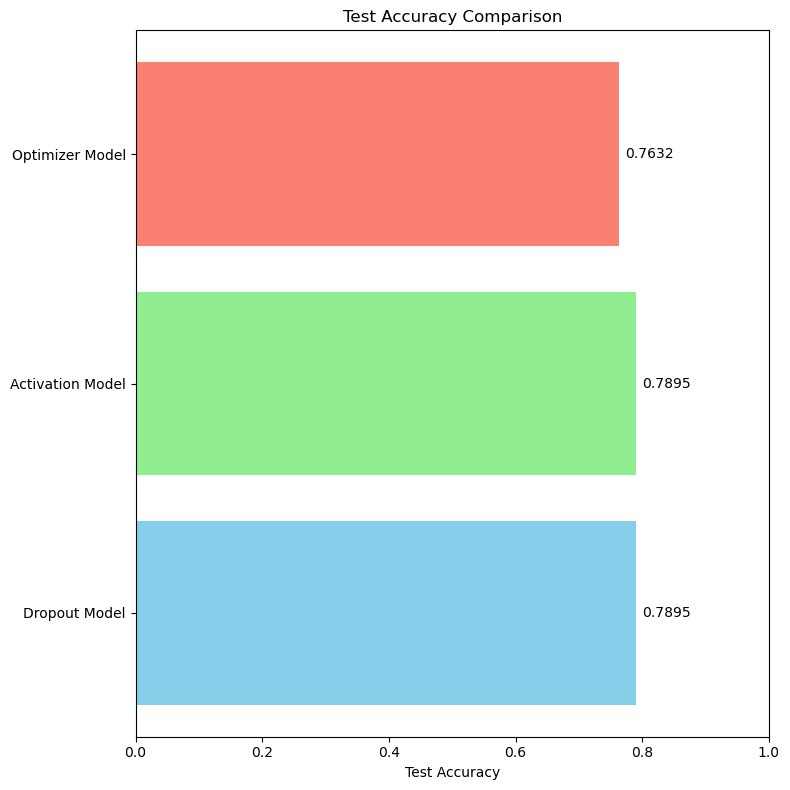

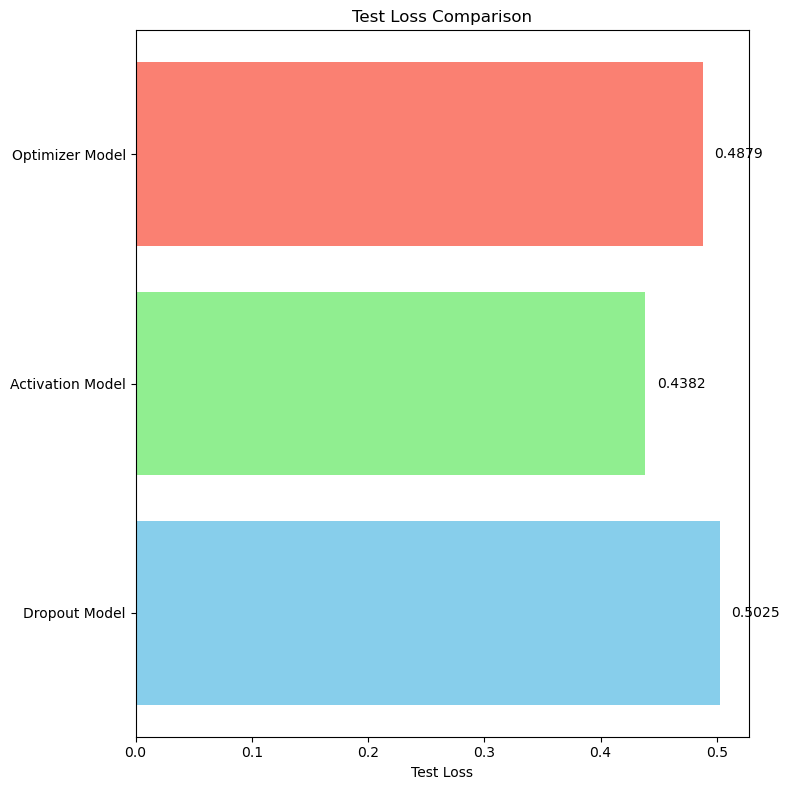

In [31]:
#Horizaontal. bar graph for TEST ACCURACY
test_accuracy_drop = history_drop['test_accuracy'][-1]  
test_accuracy_act = history_act['test_accuracy'][-1]
test_accuracy_opt = history_opt['test_accuracy'][-1]
plt.figure(figsize=(8, 8))
accuracies = [test_accuracy_drop, test_accuracy_act, test_accuracy_opt]
labels = ['Dropout Model', 'Activation Model', 'Optimizer Model']
plt.barh(labels, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
for index, value in enumerate(accuracies):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center')

plt.title('Test Accuracy Comparison')
plt.xlabel('Test Accuracy')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()




#Horizaontal. bar graph for TEST LOSS
test_loss_drop = history_drop['test_loss'][-1]
test_loss_act = history_act['test_loss'][-1]
test_loss_opt = history_opt['test_loss'][-1]
plt.figure(figsize=(8, 8))
losses = [test_loss_drop, test_loss_act, test_loss_opt]
labels = ['Dropout Model', 'Activation Model', 'Optimizer Model']
plt.barh(labels, losses, color=['skyblue', 'lightgreen', 'salmon'])

for index, value in enumerate(losses):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center')

plt.title('Test Loss Comparison')
plt.xlabel('Test Loss')
plt.tight_layout()
plt.show()


---

---

In [32]:
netdo

NeuralNetwork(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [33]:
optimizer_test_accuracies = {}

# Improve model with Dropout rate 0.4 [Model with dropout 0.4 is out base model]

## improve your model [Earrly Stopping]

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = torch.sigmoid(self.fc3(x))   
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0


In [34]:
input_features = X_train.shape[1]
hidden_size = 64
num_classes = 1 
net = NeuralNetwork(input_features, hidden_size, num_classes).to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)



patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True)

num_epochs = 30
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    #Train
    net.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += (outputs.round() == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train

    # Validation
    net.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = net(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()
            correct_val += (val_outputs.round() == val_labels.view(-1, 1)).sum().item()
            total_val += val_labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")

    early_stopping(val_loss, net)

    #stop training if early stopping is triggered
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


#Test
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor.to(device))
    test_pred = test_outputs.round()
    test_accuracy = (test_pred == y_test_tensor.view(-1, 1).to(device)).float().mean().item()
    test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1).to(device)).item()

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.cpu(), test_pred.cpu(), average='binary')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

optimizer_test_accuracies['early_stopping'] = test_accuracy


Epoch [1/30], Training Loss: 0.5411, Validation Loss: 0.5330, Validation Accuracy: 0.7522
Epoch [2/30], Training Loss: 0.4634, Validation Loss: 0.5397, Validation Accuracy: 0.7611
EarlyStopping counter: 1 out of 5
Epoch [3/30], Training Loss: 0.4563, Validation Loss: 0.5325, Validation Accuracy: 0.7345
Epoch [4/30], Training Loss: 0.4505, Validation Loss: 0.5335, Validation Accuracy: 0.7522
EarlyStopping counter: 1 out of 5
Epoch [5/30], Training Loss: 0.4411, Validation Loss: 0.5383, Validation Accuracy: 0.7522
EarlyStopping counter: 2 out of 5
Epoch [6/30], Training Loss: 0.4420, Validation Loss: 0.5323, Validation Accuracy: 0.7434
Epoch [7/30], Training Loss: 0.4416, Validation Loss: 0.5332, Validation Accuracy: 0.7434
EarlyStopping counter: 1 out of 5
Epoch [8/30], Training Loss: 0.4401, Validation Loss: 0.5337, Validation Accuracy: 0.7257
EarlyStopping counter: 2 out of 5
Epoch [9/30], Training Loss: 0.4310, Validation Loss: 0.5387, Validation Accuracy: 0.7434
EarlyStopping counte

# IMPROVE YOUR BASE MODEL [KFOLDS] 

In [35]:

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

def get_model(input_features, hidden_size, num_classes):
    model = NeuralNetwork(input_features, hidden_size, num_classes).to(device)
    return model

fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'test_accuracy': []
}

input_features = X_train.shape[1]
hidden_size = 64
num_classes = 1
num_epochs = 30

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Split data
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset=TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(dataset=TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, sampler=val_subsampler)

    # Initialize model, optimizer, and criterion for each fold
    model = get_model(input_features, hidden_size, num_classes)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    
    # Training and validation loop for each fold
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (outputs.round() == labels.view(-1, 1)).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train
        fold_performance['train_loss'].append(running_loss / len(train_loader))
        fold_performance['train_accuracy'].append(train_accuracy)

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()
                correct_val += (val_outputs.round() == val_labels.view(-1, 1)).sum().item()
                total_val += val_labels.size(0)
        
        val_accuracy = correct_val / total_val
        fold_performance['val_loss'].append(val_loss / len(val_loader))
        fold_performance['val_accuracy'].append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {running_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in DataLoader(dataset=TensorDataset(X_test_tensor, y_test_tensor), batch_size=32):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels.view(-1, 1)).item()
            correct_test += (outputs.round() == labels.view(-1, 1)).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    print(f"Test Loss: {test_loss/len(DataLoader(dataset=TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)):.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    fold_performance['test_accuracy'].append(test_accuracy)
# Average the performance over all the folds
avg_train_loss = np.mean(fold_performance['train_loss'])
avg_val_loss = np.mean(fold_performance['val_loss'])
avg_train_accuracy = np.mean(fold_performance['train_accuracy'])
avg_val_accuracy = np.mean(fold_performance['val_accuracy'])
avg_test_accuracy = np.mean(fold_performance['test_accuracy'])

print(f'\nAverage Training Loss: {avg_train_loss:.4f}')
print(f'Average Validation Loss: {avg_val_loss:.4f}')
print(f'Average Training Accuracy: {avg_train_accuracy:.4f}')
print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}')
print(f'Average test Accuracy: {avg_test_accuracy:.4f}')

optimizer_test_accuracies['k_fold'] = avg_test_accuracy


Fold 1/5
Epoch [1/30], Training Loss: 0.5764, Validation Loss: 0.5627, Validation Accuracy: 0.7358
Epoch [2/30], Training Loss: 0.4728, Validation Loss: 0.5316, Validation Accuracy: 0.7170
Epoch [3/30], Training Loss: 0.4618, Validation Loss: 0.4821, Validation Accuracy: 0.7170
Epoch [4/30], Training Loss: 0.4503, Validation Loss: 0.5703, Validation Accuracy: 0.7358
Epoch [5/30], Training Loss: 0.4335, Validation Loss: 0.4873, Validation Accuracy: 0.7264
Epoch [6/30], Training Loss: 0.4182, Validation Loss: 0.5379, Validation Accuracy: 0.7264
Epoch [7/30], Training Loss: 0.4218, Validation Loss: 0.5337, Validation Accuracy: 0.7358
Epoch [8/30], Training Loss: 0.4088, Validation Loss: 0.5705, Validation Accuracy: 0.7358
Epoch [9/30], Training Loss: 0.4110, Validation Loss: 0.5097, Validation Accuracy: 0.7453
Epoch [10/30], Training Loss: 0.4153, Validation Loss: 0.6098, Validation Accuracy: 0.7170
Epoch [11/30], Training Loss: 0.4311, Validation Loss: 0.5175, Validation Accuracy: 0.7264

# IMPROVE YOUR MODEL [LEARNING RATE]

In [36]:
input_features = X_train.shape[1]
hidden_size = 64
num_classes = 1
net = NeuralNetwork(input_features, hidden_size, num_classes).to(device)

optimizer = optim.RMSprop(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Scheduler to reduce learning rate if validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# DataLoaders for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

num_epochs = 30
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    net.train()
    
    running_loss = 0.0
    correct_train, total_train = 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct_train += (outputs.round() == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train

    # Validation phase
    net.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = net(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()
            correct_val += (val_outputs.round() == val_labels.view(-1, 1)).sum().item()
            total_val += val_labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Save the best model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(net.state_dict(), 'best_model_with_scheduler.pt')
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {best_val_accuracy:.4f}")

# Load the best model
net.load_state_dict(torch.load('best_model_with_scheduler.pt'))
net.eval()

# Testing phase
with torch.no_grad():
    test_outputs = net(X_test_tensor.to(device))
    test_pred = test_outputs.round()
    test_accuracy = (test_pred == y_test_tensor.view(-1, 1).to(device)).float().mean().item()
    test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1).to(device)).item()

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.cpu(), test_pred.cpu(), average='binary')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

optimizer_test_accuracies['learning_rate_sched'] = test_accuracy


Epoch [1/30], Training Loss: 0.5597, Validation Loss: 0.5245, Validation Accuracy: 0.7257
Best model saved at epoch 1 with validation accuracy: 0.7257
Epoch [2/30], Training Loss: 0.4690, Validation Loss: 0.5211, Validation Accuracy: 0.7611
Best model saved at epoch 2 with validation accuracy: 0.7611
Epoch [3/30], Training Loss: 0.4576, Validation Loss: 0.5222, Validation Accuracy: 0.7611
Epoch [4/30], Training Loss: 0.4494, Validation Loss: 0.5221, Validation Accuracy: 0.7345
Epoch [5/30], Training Loss: 0.4567, Validation Loss: 0.5268, Validation Accuracy: 0.7168
Epoch [6/30], Training Loss: 0.4402, Validation Loss: 0.5285, Validation Accuracy: 0.7434
Epoch [7/30], Training Loss: 0.4342, Validation Loss: 0.5287, Validation Accuracy: 0.7434
Epoch [8/30], Training Loss: 0.4352, Validation Loss: 0.5287, Validation Accuracy: 0.7434
Epoch [9/30], Training Loss: 0.4344, Validation Loss: 0.5288, Validation Accuracy: 0.7345
Epoch [10/30], Training Loss: 0.4326, Validation Loss: 0.5289, Valid

# IMPROVE YOUR MODEL [BATCHNORMALIZATION]

In [52]:
class NeuralNetworkWithBatchNorm(nn.Module):
    def __init__(self, input_features, hidden_size, num_classes):
        super(NeuralNetworkWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  #batch normalization
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)  #batch normalization
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # batch norm after first activation
        x = F.relu(self.bn2(self.fc2(x)))  #batch norm after second activation
        x = torch.sigmoid(self.fc3(x))
        return x

In [55]:
input_features = X_train.shape[1]
hidden_size = 64
num_classes = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_bn = NeuralNetworkWithBatchNorm(input_features, hidden_size, num_classes).to(device)
optimizer = optim.RMSprop(net_bn.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

history_batch = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
}

num_epochs = 30
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    net_bn.train()  
    
    running_loss = 0.0
    correct_train, total_train = 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_bn(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct_train += (outputs.round() == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train

    # Validation phase
    net_bn.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = net_bn(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()
            correct_val += (val_outputs.round() == val_labels.view(-1, 1)).sum().item()
            total_val += val_labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(net_bn.state_dict(), 'minazmeh_aramired_assignment2_part2.pt')
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {best_val_accuracy:.4f}")

    history_batch['train_loss'].append(running_loss / len(train_loader))
    history_batch['train_accuracy'].append(train_accuracy)
    history_batch['val_loss'].append(val_loss)
    history_batch['val_accuracy'].append(val_accuracy)


net_bn.load_state_dict(torch.load('minazmeh_aramired_assignment2_part2.pt'))
net_bn.eval()

# Testing phase
with torch.no_grad():
    test_outputs = net_bn(X_test_tensor.to(device))
    test_pred = test_outputs.round()
    test_accuracy = (test_pred == y_test_tensor.view(-1, 1).to(device)).float().mean().item()
    test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1).to(device)).item()

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.cpu(), test_pred.cpu(), average='binary')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
optimizer_test_accuracies['batch_norm'] = test_accuracy

Epoch [1/30], Training Loss: 0.5257, Validation Loss: 0.5450, Validation Accuracy: 0.7345
Best model saved at epoch 1 with validation accuracy: 0.7345
Epoch [2/30], Training Loss: 0.4644, Validation Loss: 0.5353, Validation Accuracy: 0.7434
Best model saved at epoch 2 with validation accuracy: 0.7434
Epoch [3/30], Training Loss: 0.4522, Validation Loss: 0.5408, Validation Accuracy: 0.7257
Epoch [4/30], Training Loss: 0.4387, Validation Loss: 0.5516, Validation Accuracy: 0.7080
Epoch [5/30], Training Loss: 0.4313, Validation Loss: 0.5425, Validation Accuracy: 0.7257
Epoch [6/30], Training Loss: 0.4456, Validation Loss: 0.5360, Validation Accuracy: 0.7168
Epoch [7/30], Training Loss: 0.4450, Validation Loss: 0.5183, Validation Accuracy: 0.7434
Epoch [8/30], Training Loss: 0.4233, Validation Loss: 0.5360, Validation Accuracy: 0.7168
Epoch [9/30], Training Loss: 0.4246, Validation Loss: 0.5263, Validation Accuracy: 0.7611
Best model saved at epoch 9 with validation accuracy: 0.7611
Epoch [

In [56]:
print(optimizer_test_accuracies)

{'early_stopping': 0.780701756477356, 'k_fold': 0.7789473684210526, 'learning_rate_sched': 0.780701756477356, 'batch_norm': 0.8157894611358643}


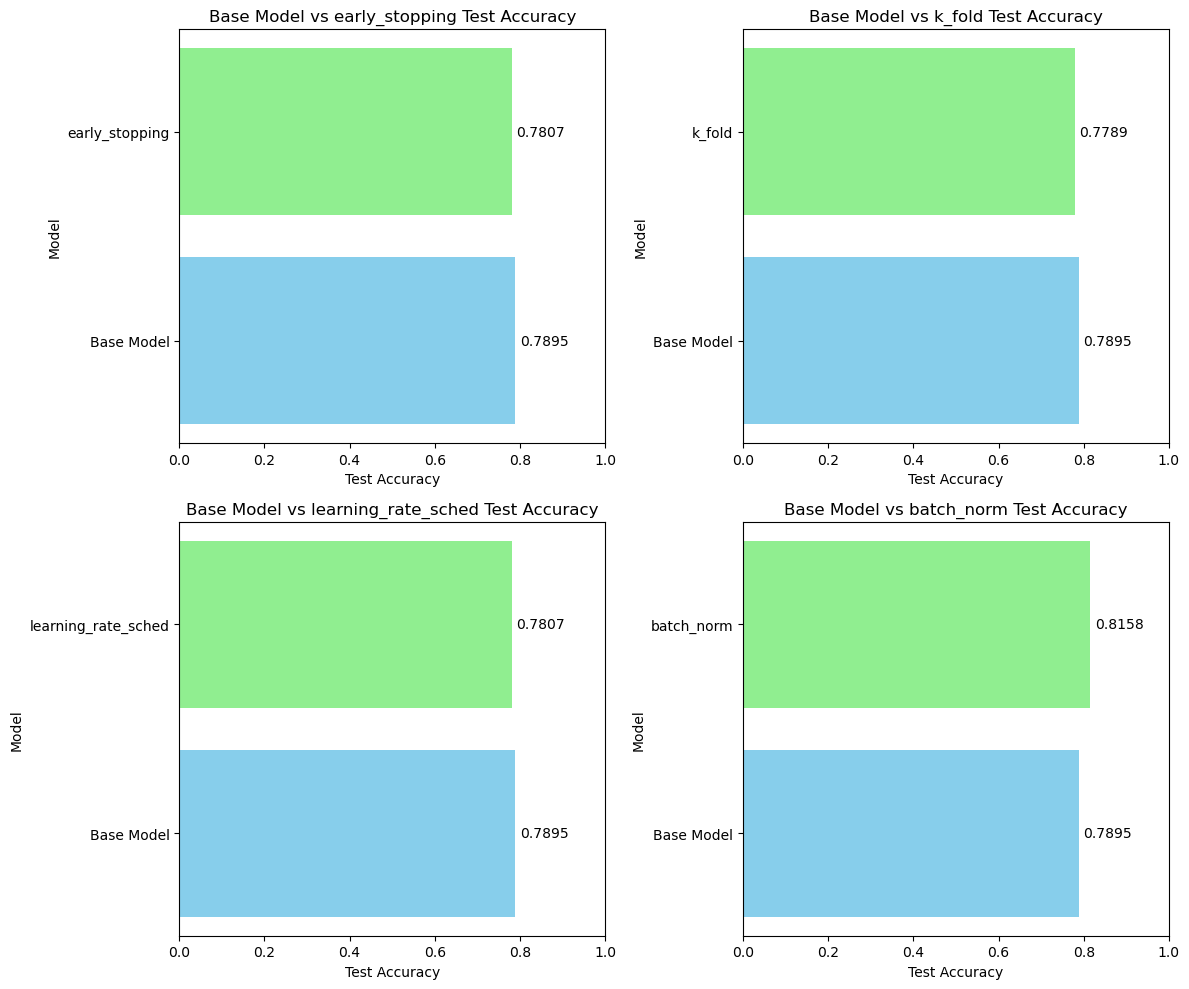

In [57]:

num_optimizers = len(optimizer_test_accuracies)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust figure size

axes = axes.flatten()

for i, (optimizer_name, optimizer_test_accuracy) in enumerate(optimizer_test_accuracies.items()):
    
    accuracies = [test_accuracy_base_model, optimizer_test_accuracy]
    labels = ['Base Model', optimizer_name]
    
    axes[i].barh(labels, accuracies, color=['skyblue', 'lightgreen'])
    axes[i].set_xlim(0, 1)  # Assuming accuracy is between 0 and 1
    
    for index, value in enumerate(accuracies):
        axes[i].text(value + 0.01, index, f'{value:.4f}', va='center')  # Add values slightly to the right of the bars
    
    # Titles and labels
    axes[i].set_title(f'Base Model vs {optimizer_name} Test Accuracy')
    axes[i].set_ylabel('Model')
    axes[i].set_xlabel('Test Accuracy')

# Remove any empty subplots if there are less than 4 optimizers
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the final figure with all subplots
plt.show()


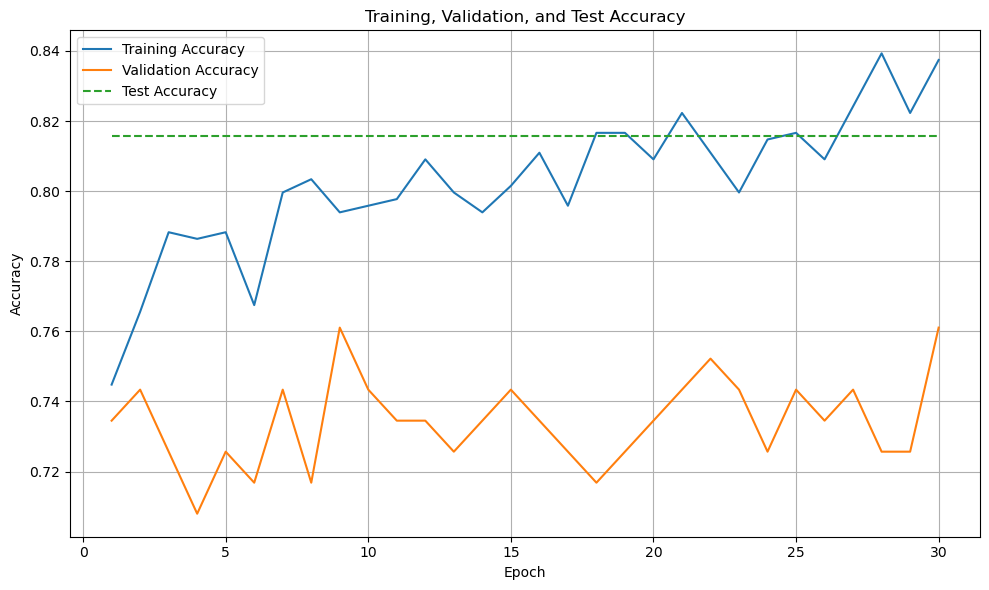

In [58]:
test_accuracy_repeated = [test_accuracy] * num_epochs
test_loss_repeated = [test_loss] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), history_batch['train_accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history_batch['val_accuracy'], label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracy_repeated, label='Test Accuracy', linestyle='--')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

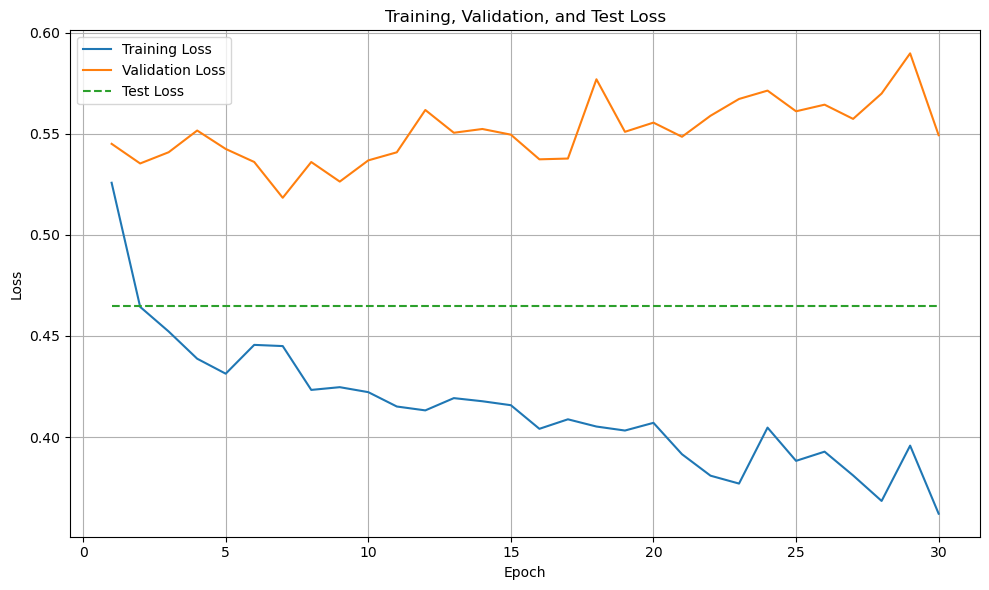

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), history_batch['train_loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history_batch['val_loss'], label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_loss_repeated, label='Test Loss', linestyle='--')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

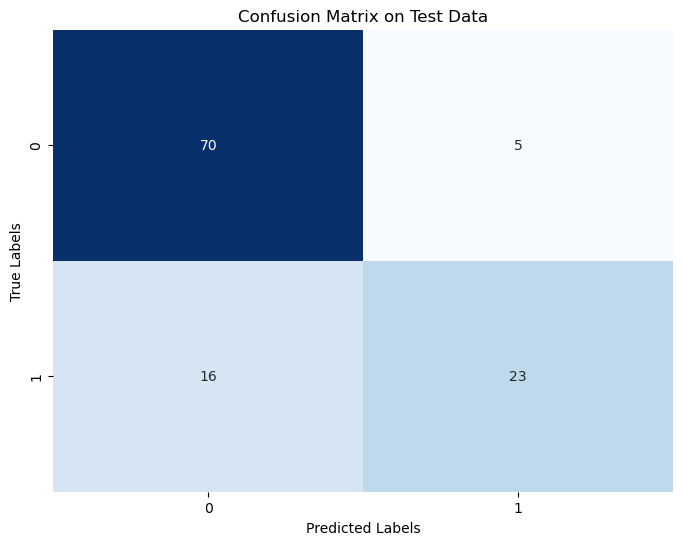

In [60]:
conf_matrix = confusion_matrix(y_test_tensor.cpu(), test_pred.cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix on Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

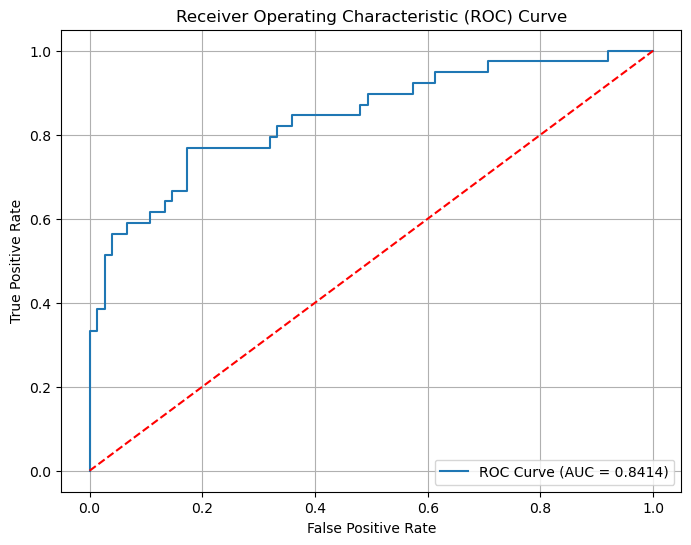

In [61]:
test_prob = test_outputs.cpu().detach().numpy()  
true_labels = y_test_tensor.cpu().numpy()

fpr, tpr, _ = roc_curve(true_labels, test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')  
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
